<a href="https://colab.research.google.com/github/DakaiZhou/machine-learning-algorithm-implementation/blob/main/Logistic_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Classiﬁcation and logistic regression
The linear regression can be modified to classification problem, by reduce y to discrete values. For now, we focus on **binary classification**, and it it y is either $0$ nor $1$.

## Logistic regression
Simply use linear regression to predit binary classification ($y \in \{0,1\}$) performs poorly. To fix this, we change our $h_\theta(x)$:

\begin{gather}
h_\theta(x) = g(\theta^Tx) = \frac{1}{1 + e^{-\theta^Tx}}
\end{gather}

where $g(z) = \frac{1}{1+e^{-z}}$ , which is called **logistic function** or **sigmoid function**. $g(z)$ tends toward to 1 as $z \rightarrow \infty$, and tends toward to 0 as $z \rightarrow -\infty$.

Keeping $x_0 = 1$ as in linear regression, $\theta^Tx = \theta_0 + \sum_{j=1}^n \theta_jx_j$.

One useful property of sigmoid function is:
\begin{align}
g'(z) &= \frac{d}{dz}\frac{1}{1 + e^{-z}}\\
&= \frac{1}{(1+e^{-z})^2}(e^{-z})\\
&= \frac{1}{(1+e^{-z})}(1- \frac{1}{(1+e^{-z})})\\
&= g(z)(1-g(z))
\end{align}

To estimate $\theta$, we do maximum likelihood estimator under a set of asumptions (similar to least squares regression). Assume that 
\begin{gather}
P(y=1|x;\theta) = h_\theta(x)
\end{gather}

\begin{gather}
P(y=0|x;\theta) = 1-h_\theta(x)
\end{gather}

This can be written as 

\begin{gather}
p(y|x;\theta) = (h_\theta(x))^y(1-h_\theta(x))^{1-y}
\end{gather}

Assuming we have $m$ training examples which were generated independently, we write down the likelihood of the parameters as
\begin{align}
L(\theta) &= p(\vec y| X;\theta)\\
&= \prod_{i=1}^m p(y^{(i)}|x^{(i)};\theta)\\
&= \prod_{i=1}^m (h_\theta(x^{(i)}))^{y^{(i)}} (1-h_\theta(x^{(i)}))^{1-y^{(i)}}
\end{align}

\begin{align}
l(\theta) &= \log L(\theta)\\
&= \sum_{i=1}^m y^{(i)}\log h(x^{(i)}) + (1- y^{(i)})\log(1-h(x^{(i)}))
\end{align}

Again, similar to the derivation in the case of linear regression, we can use gradient ascent to maximize the likelihood. $\theta := \theta + \alpha \nabla_\theta l(\theta)$ (plus is because we are maximizing the function).
With one training example and the usful property, we have:

\begin{align}
\frac{\partial}{\partial \theta_j}l(\theta) &= (y \frac{1}{g(\theta^T x) - (1-y)\frac{1}{1-g(\theta^Tx)}})\frac{\partial}{\partial\theta_j}g(\theta_j x)\\
&= (y \frac{1}{g(\theta^T x) - (1-y)\frac{1}{1-g(\theta^Tx)}})g(\theta^Tx)(1-g(\theta^Tx)\frac{\partial}{\partial\theta_j}\theta^Tx\\
&= (y(1-g(\theta^Tx))-(1-y)g(\theta^Tx))x_j\\
&= (y-h(\theta^Tx))x_j
\end{align}

Therefore, it give us the stochastic gradient ascent rule: 
\begin{gather}
\theta_j := \theta_j + \alpha(y^{(i)}-h_\theta(x^{(i)}))x_j^{(i)}
\end{gather}

Of course, we can also change it to a batch gradient ascent:
\begin{gather}
\theta_j := \theta_j + \alpha\sum_{i=1}^m(y^{(i)}-h_\theta(x^{(i)}))x_j^{(i)}
\end{gather}

Here, the cost function $J(\theta)$ becomes $l(\theta)$ written above.

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np

In [2]:
df = pd.read_csv("challenger.csv")
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23 entries, 0 to 22
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   failure      23 non-null     bool 
 1   temperature  23 non-null     int64
dtypes: bool(1), int64(1)
memory usage: 335.0 bytes


,failure,temperature
0,False,66
1,True,70
2,False,69
3,False,68
4,False,67


In [3]:
df.loc[df['failure'] == False, ["failure"]] = 0
df.loc[df['failure'] == True, ["failure"]] = 1
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23 entries, 0 to 22
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   failure      23 non-null     object
 1   temperature  23 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 496.0+ bytes


,failure,temperature
0,0,66
1,1,70
2,0,69
3,0,68
4,0,67


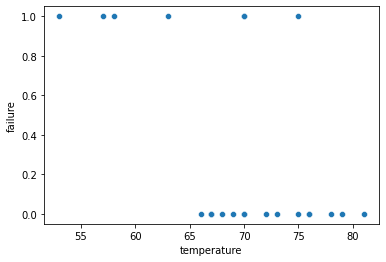

In [4]:
sns.scatterplot(data=df, x="temperature", y="failure")

In [5]:
def logistic_regression(x, y, *args, **kwargs):
  """
  Implementation for logistic regression. It is a batch logistic regression.

  Input: x training data, column vector or matrix, each column for one feature
         y training data, ground truth, column vector
         alpha learning rate optional
         tol tolorance optional

  Output: theta estimated parameters
          h estimations
  """

  alpha = 10**-3
  tol = 10**-5

  if len(kwargs) > 2:
    raise Exception("Too many inputs.")
  elif len(kwargs) > 0:
    if "alpha" in kwargs.keys():
      alpha = kwargs["alpha"]
    if "tol" in kwargs.keys():
      tol = kwargs["tol"]

  num_feature = np.shape(x)[1]
  num_example = np.shape(x)[0]
  theta = np.zeros((num_feature + 1, 1))
  new_col = np.ones(num_example)
  x = np.insert(x, 0, new_col, axis=1)
  pj = 0
  num_loop = 0

  # start gradient ascent 
  while num_loop < 10000:
    for i in range(num_example):
      h = 1 / (1 + np.exp(-np.dot(x, theta).astype(float)))
      tmp = sum((y - h) * x)
      theta = theta + alpha * tmp.reshape((num_feature + 1, 1)) # theta update
      j = sum(y*np.log(h) + (1-y)*np.log(1-h)) # cost function
      if abs(j - pj) <= tol:
        return theta, h
      else:
        pj = j
    num_loop = num_loop + 1

  print("gradient descent does not convergence after maximum interation.")
  return theta, h

In [6]:
x = df["temperature"].values
y = df['failure'].values
n = np.size(y)
x = x.reshape((n, 1))
y = y.reshape((n, 1))
theta1, h1 = logistic_regression(x, y) 

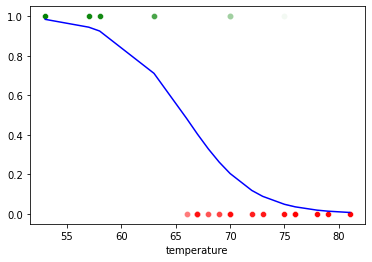

In [7]:
transparent = h1.reshape(n)

for idx, val in enumerate(df['failure']):
  if val == 1:
    sns.scatterplot(x=[df["temperature"][idx]], y=val, alpha=transparent[idx], color="green")
  else:
    sns.scatterplot(x=[df["temperature"][idx]], y=val, alpha=1-transparent[idx], color="red")
sns.lineplot(data=df, x="temperature", y=h1.reshape(np.size(h1)), color='blue')

One advantage of logistic regression is that it gives the probability of each instance belongs to a class. It makes a big difference knowing a instance has a 99% probability for a class compared to 51%. The transparency in the plot above inicates the probability of the instance for the class. Deeper color stands for higher probability(some points have deeper color than it should have, it because multiple points overlap to each other, e.g. temperature=67). 

If we set any point with probebiliy larger than 0.5 as green, and others as red, we get the following plot. The transparency is again the the probability of the instance for the class.

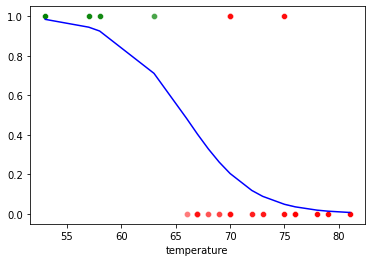

In [10]:
for idx, val in enumerate(df['failure']):
  if h1[idx] > 0.5:
    sns.scatterplot(x=[df["temperature"][idx]], y=val, alpha=transparent[idx], color="green")
  else:
    sns.scatterplot(x=[df["temperature"][idx]], y=val, alpha=1-transparent[idx], color="red")
sns.lineplot(data=df, x="temperature", y=h1.reshape(np.size(h1)), color='blue')